In [3]:
import numpy as np    
import pandas as pd  
import matplotlib.pyplot as plt 
import seaborn as sns


In [4]:
## read in the data stored in the file 'SportGamblingExtended.csv'
rawData = pd.read_csv (r'SportGamblingExtended.csv') 

rawData.head(10)

,UserID,CountryID,Gender,BirthYear,DateReg,TimeReg,Date1Dep,Date1Bet,Date1Spo,StakeF,...,StakeA,WinF,WinL,WinA,BetsF,BetsL,BetsA,DaysF,DaysL,DaysA
0,1324354,276,1,1963,2005-02-01,00:01,2005-02-24,2005-02-24,2005-02-24,15750.3800,...,17896.8500,15010.9000,1809.9500,16820.8500,727,71,798,231,33,233
1,1324355,300,1,1983,2005-02-01,00:05,2005-02-01,2005-02-01,2005-02-01,639.2998,...,663.9998,569.3700,11.2000,580.5700,286,21,307,99,7,101
2,1324356,276,1,1977,2005-02-01,00:05,2005-02-01,2005-02-02,2005-02-02,898.8100,...,1600.6300,336.3600,649.2700,985.6300,116,126,242,48,27,54
3,1324358,752,1,1981,2005-02-01,00:08,2005-02-01,2005-02-01,2005-02-01,247.6970,...,336.2897,153.8755,55.9819,209.8574,7,4,11,5,1,5
4,1324360,792,1,1978,2005-02-01,00:09,2005-02-02,2005-02-02,2005-02-02,685.9424,...,692.6065,623.8984,3.0528,626.9512,386,8,394,58,4,60
5,1324362,276,1,1983,2005-02-01,00:09,2005-02-11,2005-02-11,2005-02-11,274.4200,...,283.4200,189.7400,26.5000,216.2400,169,7,176,57,3,57
6,1324363,208,1,1983,2005-02-01,00:15,2005-02-01,2005-02-01,2005-02-01,41.5300,...,41.5300,0.0000,0.0000,0.0000,3,0,3,3,0,3
7,1324364,276,1,1968,2005-02-01,00:15,2005-02-03,2005-02-03,2005-02-03,242.0000,...,562.0000,198.0000,95.6500,293.6500,43,70,113,22,28,46
8,1324368,620,1,1983,2005-02-01,00:20,2005-03-18,2005-03-18,2005-03-18,2043.8900,...,8246.4600,1931.7800,6144.6200,8076.4000,150,347,497,57,68,89
9,1324369,792,1,1985,2005-02-01,00:23,2005-02-01,2005-02-01,2005-02-01,591.3060,...,1535.4313,580.6762,865.1772,1445.8534,302,223,525,96,67,109


In [5]:
# Pre-processing
# remove the irrelevant columns: 'CountryID', 'Gender', 'DateReg', 'TimeReg',
#'Date1Dep','Date1Bet', 'Date1Spo', 'StakeF', 'StakeL', 'WinF', 'WinL', 'BetsF', 'BetsL', 'DaysF', 'DaysL' 

# return new dataframe "data"
data = rawData.drop(['CountryID', 'Gender', 'DateReg', 'TimeReg',
                     'Date1Dep','Date1Bet', 'Date1Spo', 'StakeF', 'StakeL', 
                     'WinF', 'WinL', 'BetsF', 'BetsL', 'DaysF', 'DaysL'], axis=1)
# change column names
data.columns = ['UserID', 'BirthYear', 'TotalSpendings', 'TotalEarnings', 'Bets', 'Days']

# filter datapoints that represent inactive players (players that did not make any bet during the research period)
data = data[data['TotalSpendings'] > 0]

data.head(10)

,UserID,BirthYear,TotalSpendings,TotalEarnings,Bets,Days
0,1324354,1963,17896.8500,16820.8500,798,233
1,1324355,1983,663.9998,580.5700,307,101
2,1324356,1977,1600.6300,985.6300,242,54
3,1324358,1981,336.2897,209.8574,11,5
4,1324360,1978,692.6065,626.9512,394,60
5,1324362,1983,283.4200,216.2400,176,57
6,1324363,1983,41.5300,0.0000,3,3
7,1324364,1968,562.0000,293.6500,113,46
8,1324368,1983,8246.4600,8076.4000,497,89
9,1324369,1985,1535.4313,1445.8534,525,109


In [6]:
# add 2 new columns: AverageBet (the average amount of money that an user spends on a bet) and 
# Profit (user's total earnings - user's total spendings)
data['AverageBet'] = np.divide(data['TotalSpendings'], data['Bets'])
data['Profit'] = data['TotalEarnings'] - data['TotalSpendings']
data.head(10)

,UserID,BirthYear,TotalSpendings,TotalEarnings,Bets,Days,AverageBet,Profit
0,1324354,1963,17896.8500,16820.8500,798,233,22.427130,-1076.0000
1,1324355,1983,663.9998,580.5700,307,101,2.162866,-83.4298
2,1324356,1977,1600.6300,985.6300,242,54,6.614174,-615.0000
3,1324358,1981,336.2897,209.8574,11,5,30.571791,-126.4323
4,1324360,1978,692.6065,626.9512,394,60,1.757885,-65.6553
5,1324362,1983,283.4200,216.2400,176,57,1.610341,-67.1800
6,1324363,1983,41.5300,0.0000,3,3,13.843333,-41.5300
7,1324364,1968,562.0000,293.6500,113,46,4.973451,-268.3500
8,1324368,1983,8246.4600,8076.4000,497,89,16.592475,-170.0600
9,1324369,1985,1535.4313,1445.8534,525,109,2.924631,-89.5779


/opt/software/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


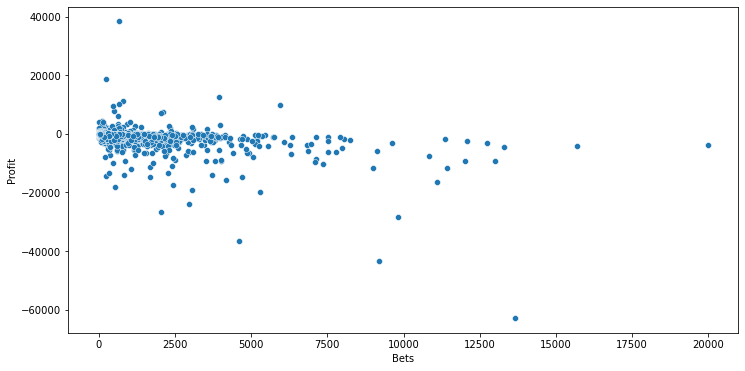

In [23]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data['Bets'], data['Profit'])
plt.savefig('Bets_profit')

/opt/software/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


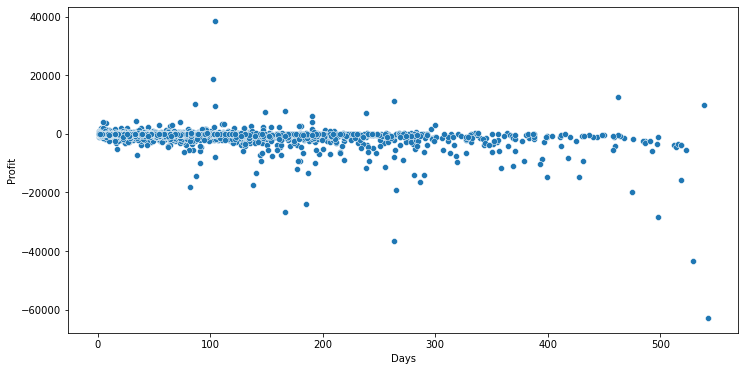

In [25]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data['Days'], data['Profit'])
plt.savefig('Days_profit.png')

/opt/software/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


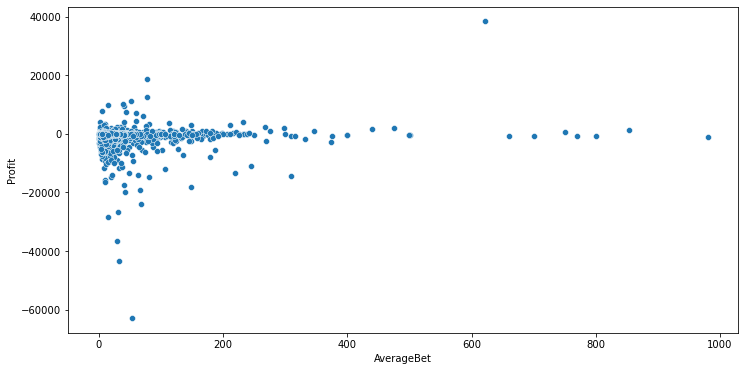

In [26]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data['AverageBet'], data['Profit'])
plt.savefig('AverageBet_profit.png')

In [13]:
from sklearn.preprocessing import PolynomialFeatures    
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# select the property 'TotalBets', 'TotalDays' and 'AverageBet' for
# each row of 'data' as features X and 'Profit' as labels y

X = data.drop(['UserID', 'BirthYear', 'TotalSpendings', 'TotalEarnings','Profit'],axis=1).to_numpy().reshape(-1,3)
y = data['Profit'].to_numpy()

# split the data into training, validation, and test sets.
X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# split the training set into training set and validation set. 
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=0.25, random_state=42)





In [22]:
#polynomial regression
poly_train_errors = []
poly_val_errors = []
poly_degrees = []

lin_regr = LinearRegression(fit_intercept=False)

for degree in range (2,8):
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    lin_regr.fit(X_train_poly, y_train)
    
    y_train_pred = lin_regr.predict(X_train_poly)
    train_error = mean_absolute_error(y_train, y_train_pred)
    
    X_val_poly = poly.fit_transform(X_val)
    y_val_pred = lin_regr.predict(X_val_poly)
    val_error = mean_absolute_error(y_val, y_val_pred)
    
    poly_train_errors.append(train_error)
    poly_val_errors.append(val_error)
    poly_degrees.append(degree)
    
print(poly_train_errors)
print(poly_val_errors)

[324.10743053275377, 264.9477970108303, 241.06357454999812, 288.9604703802978, 307.2733568623047, 340.4370088122984]
[360.4502286615159, 328.5881102120537, 388.2202921005701, 2514.9282659552377, 2872.435070730874, 19789.242743834006]


In [23]:
#validation error & test error
lin_regr = LinearRegression(fit_intercept = False)

poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)
lin_regr.fit(X_train_poly, y_train)

X_val_poly = poly.fit_transform(X_val)
X_test_poly = poly.fit_transform(X_test)

y_val_pred = lin_regr.predict(X_val_poly)
y_test_pred = lin_regr.predict(X_test_poly)

test_error = mean_absolute_error(y_test, y_test_pred)
val_error = mean_absolute_error(y_val, y_val_pred)

print(val_error)
print(test_error)



328.5881102120537
277.59347214393426


In [24]:
#decision tree regressor
from sklearn.tree import DecisionTreeRegressor
decst_train_errors = []
decst_val_errors = []
max_depths = []

for depth in range(1, 9):
    decst_regr = DecisionTreeRegressor(max_depth=depth, random_state=0)
    decst_regr.fit(X_train, y_train)
    
    y_train_pred_decst = decst_regr.predict(X_train)
    train_error_decst = mean_absolute_error(y_train, y_train_pred_decst)
    
    y_val_pred_decst = decst_regr.predict(X_val)
    val_error_decst = mean_absolute_error(y_val, y_val_pred_decst)  
    
    decst_train_errors.append(train_error_decst)
    decst_val_errors.append(val_error_decst)
    
print(decst_train_errors)
print(decst_val_errors)


[344.62885771873863, 330.85393584311055, 292.65428015128936, 267.27429788432147, 245.65854597016707, 225.56494197708295, 199.68935282429294, 174.24931692918926]
[403.4198736496235, 396.3198157853829, 360.31449809498, 344.37603792152214, 331.62124968666217, 338.61903269424437, 349.5252282595252, 376.4435910107664]


In [25]:
#validation error & test error
decst_regr = DecisionTreeRegressor(max_depth=5, random_state=0)
decst_regr.fit(X_train, y_train)

y_val_pred_decst = decst_regr.predict(X_val)
val_error_decst = mean_absolute_error(y_val, y_val_pred_decst)

y_test_pred_decst = decst_regr.predict(X_test)
test_error_decst = mean_absolute_error(y_test, y_test_pred_decst)

print(val_error_decst)
print(test_error_decst)

331.62124968666217
268.1374281831715
